In [1]:
# Подключаемые библиотеки

# библиотеки для работы с массивами данных
import pandas as pd
import numpy as np
# библиотеки для визуализации данных
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

# библиотеки машинного обучения PyTotch
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

# дополнительные библиотеки
from tqdm import tqdm
from time import sleep
import datetime

In [2]:
# загрузка данных с изображениями
folder_path = '/kaggle/input/severstal-steel-defect-detection/'
images_path = folder_path + 'train_images/' 

tab = pd.read_csv(folder_path+'train.csv')
c = 4
tab = tab[tab['ClassId'] == c].copy()
tab = tab.reset_index().drop('index', axis = 1)
image_list = tab['ImageId'].unique()
tab

,ImageId,ClassId,EncodedPixels
0,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg,4,215548 3 215798 9 216051 12 216306 13 216560 1...
...,...,...,...
796,fda1a539d.jpg,4,128621 3 128876 8 129131 11 129386 13 129641 1...
797,fdb7c0397.jpg,4,155020 6 155268 16 155516 27 155764 37 156012 ...
798,feec56162.jpg,4,99346 1 99602 1 99858 1 100113 2 100369 3 1006...
799,ff6bfada2.jpg,4,90877 2 91131 4 91385 6 91638 9 91892 12 92146...


In [3]:
# функция для определения местоположения дефекта
def pix_to_mat(pixels, h , w):
    p_list = pixels.split()
    start = np.array(p_list[0::2]).astype(int)
    length = np.array(p_list[1::2]).astype(int)
    n = len(start)
    m = np.zeros(h*w)
    for i in range(n):
        m[start[i] - 1 : start[i] - 1 + length[i]] = 1
    m = m.reshape(w,h).T
    return m

Number of Defect Pixels: 13745 out of 409600 pixels.


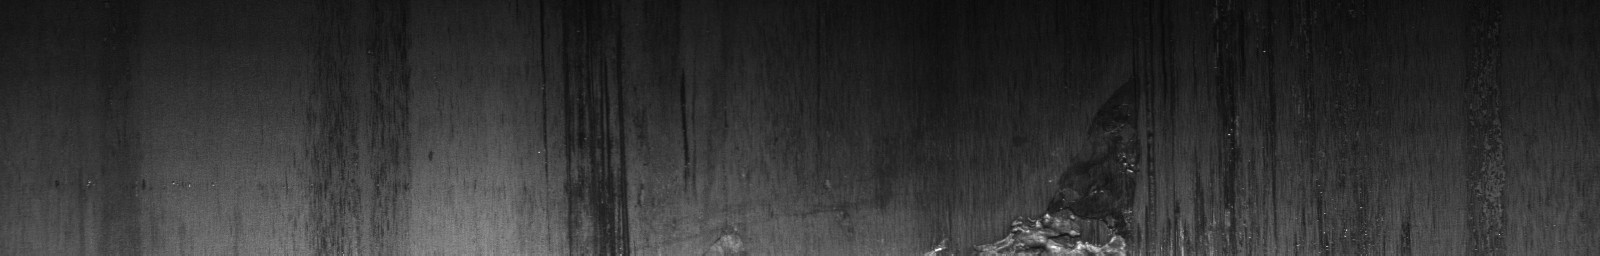

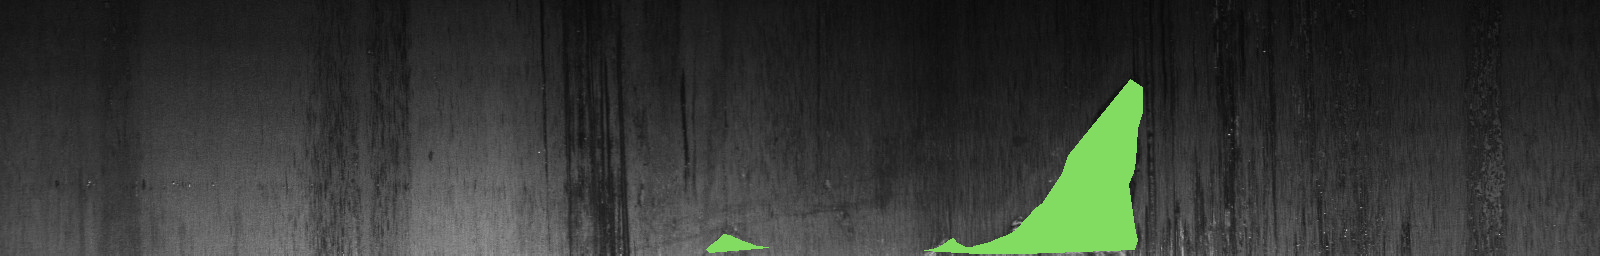

Number of Defect Pixels: 5989 out of 409600 pixels.


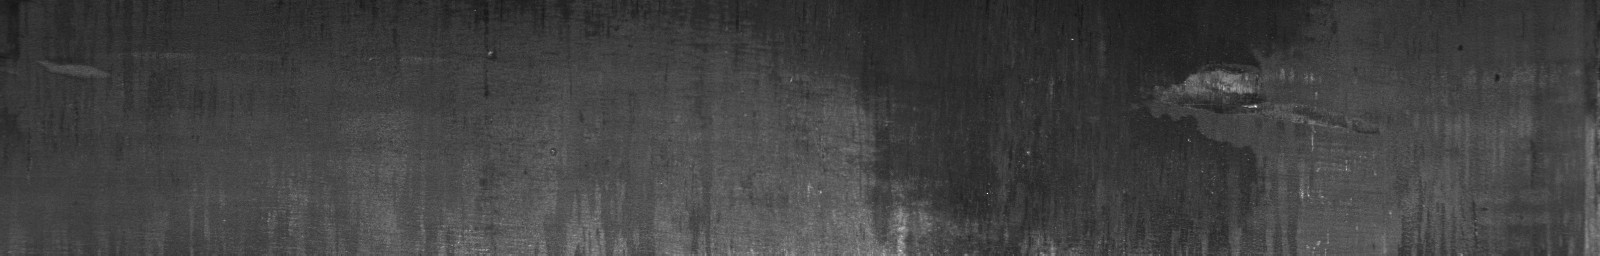

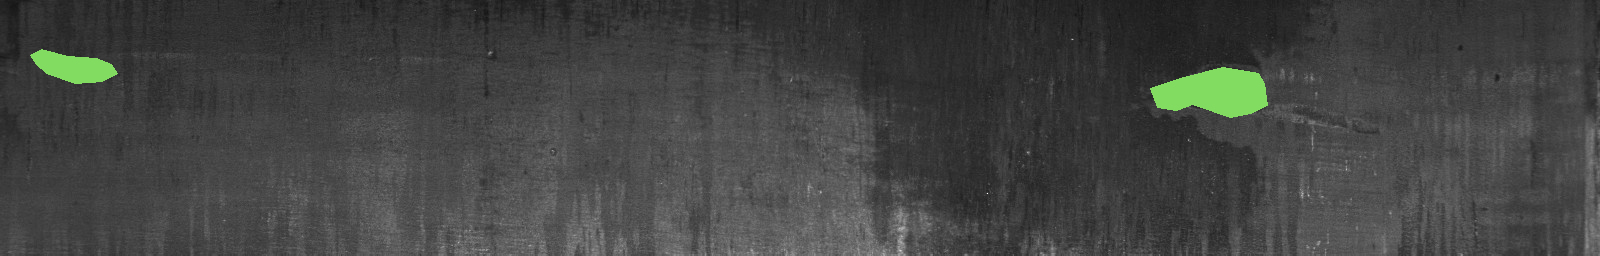

Number of Defect Pixels: 93452 out of 409600 pixels.


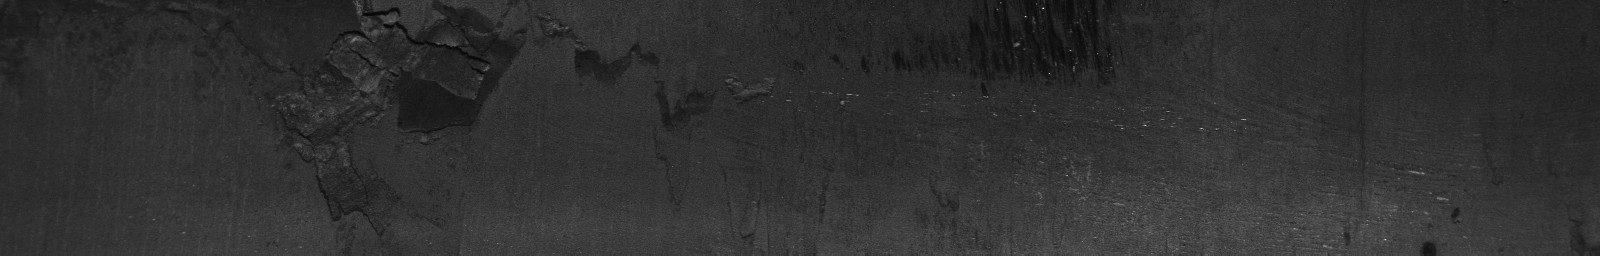

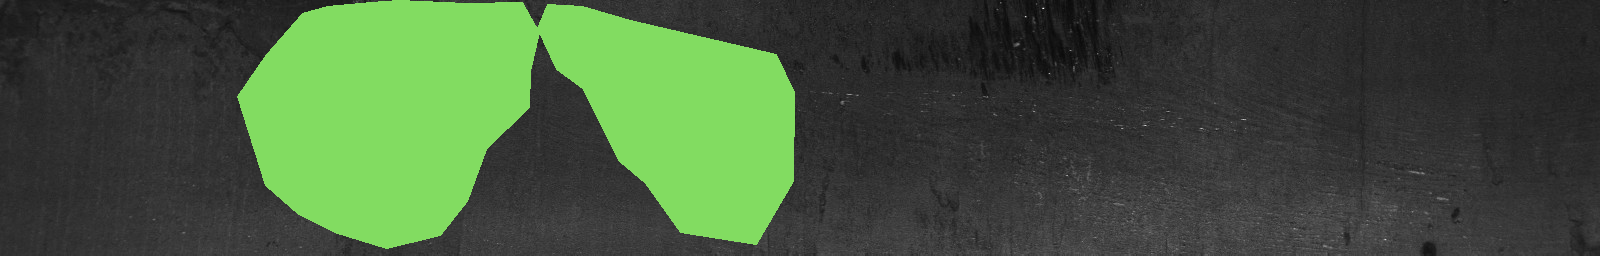

In [5]:
# Функция для отображения областей с дефектами на изображениях
def imageshow(imageid):
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    img = mpimg.imread(images_path + imageid).transpose(-1,0,1)
    img[0, image_mask == 1] = 130
    img[1, image_mask == 1] = 220
    img[2, image_mask == 1] = 97
    print(f'Number of Defect Pixels: {round(image_mask.sum())} out of {256*1600} pixels.')
    display(Image.open(images_path + imageid))
    display(Image.fromarray(img.transpose(1,2,0)))

for i in range(3):
    imageid = np.random.choice(image_list)
    imageshow(imageid)

In [6]:
# разделяем набор данных на три набора: тренировочный, валидный и тестовый

print(len(image_list)) # всего имеем 801 изображение

# количество изображений для валидации и тестирования
n = 30

# случайным образом выберем 30 изображений для валидации
val = list(np.random.choice(image_list, n, replace = False))
train = list(set(image_list) - set(val))
# случайным образом выберем 30 изображений для тестирования
test = list(np.random.choice(train, n, replace = False))
train = list(set(train) - set(test)) # оставшиеся изображения составят тренировочный набор 
# вывод количества изображений в каждом блоке
for l in train, val, test:
    print(len(l))
    
print(test[:2])

801
741
30
30
['4b16dc9ee.jpg', 'f8d0b85ef.jpg']


In [7]:
# Обрезка входных изображений (256 х 1600) на снимки 256 х 256
# На вход U-Net должны подаваться изображения 256 х 256

# создание массивов с позициями обрезки изображений
train_pos = []
valtest_pos = []

for i in range(0,32):
    train_pos.append(i * 40)
    
train_pos.append(1344)

for j in range(0,11):
    valtest_pos.append(j * 130)

valtest_pos.append(1344)

print(len(train_pos))
print(len(valtest_pos))

33
12


In [8]:
# обрезка изображений
train_expanded = []
val_expanded = []
test_expanded = []

for imageid in train:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in train_pos:
        
        if image_mask[:,p:p+256].sum() > 12000:
            
            train_expanded.append(imageid + '_' + str(p))
            
for imageid in val:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in valtest_pos:
        
        if image_mask[:,p:p+256].sum() > 5000:
            
            val_expanded.append(imageid + '_' + str(p))

for imageid in test:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in valtest_pos:
        
        if image_mask[:,p:p+256].sum() > 5000:
            
            test_expanded.append(imageid + '_' + str(p))
            
print(len(train_expanded))
print(len(val_expanded))
print(len(test_expanded))

4679
107
109


In [9]:
# Нормализация обрезанных изображений

# Параметры нормализации
MEAN =  99.45881939063021 # среднее значение пикселя по train data
STD =  50.285401061795476 # стандартное отклонение по train data

t1 = transforms.ToTensor() # перевод изображения в тензор
vf = transforms.RandomVerticalFlip() # случайный вертикальный поворот
hf = transforms.RandomHorizontalFlip() # случайный горизонтальный поворот

# класс нормализации изображений
class data(Dataset):
    
    def __init__(self, list_expanded, data_type): 
                    #data_type: 'train', 'val', or 'test.
        
        self.list_expanded = list_expanded
        self.data_type = data_type
    
    def __len__(self):
        
        return len(self.list_expanded)
    
    def __getitem__(self, idx):
        
        imageid = self.list_expanded[idx].split('_')[0]
        p =  int(self.list_expanded[idx].split('_')[1])
        image = Image.open(images_path + imageid)

        m = MEAN/255
        s = STD/255
        
        # нормализация изображений по параметрам m и s
        t2 = transforms.Normalize(mean = m , std = s)
        
        # переводим изображение RGB в одноканальное
        img_tensor = t2(t1(image)[0].unsqueeze(0))

        X_ = img_tensor[:, :, p : p + 256]

        pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
        image_mask = pix_to_mat(pixels, 256, 1600)
        y_ = torch.tensor(image_mask).unsqueeze(0)[:, :, p : p + 256]
        
        if self.data_type == 'train':
            
            if np.random.randint(1,3) == 1:
                X_ = vf(X_)  
                y_ = vf(y_)

            if np.random.randint(1,3) == 1:
                X_ = hf(X_)
                y_ = hf(y_)

        return X_, y_

torch.manual_seed(6)
    
traindata = data(train_expanded, 'train')
valdata = data(val_expanded, 'val')
testdata = data(test_expanded, 'test') 

# Формирование загрузчиков данных
trainloader = DataLoader(traindata, batch_size = 16, shuffle = True)
valloader = DataLoader(valdata, batch_size = len(val_expanded))
testloader = DataLoader(testdata, batch_size = len(test_expanded))

In [12]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1): 
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [13]:
if torch.cuda.is_available():
    device = 'cuda'
print(device)

class DoubleConvs(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.ic = in_channels
        self.oc = out_channels
        self.conv1 = nn.Conv2d(self.ic, self.oc, kernel_size = 3, padding = 1) 
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(self.oc, self.oc, kernel_size = 3, padding = 1) 
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        
        return x

class UNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.cs = [1,32,64,128,256,512]
        self.DownConvs = nn.ModuleList(DoubleConvs(self.cs[i],self.cs[i+1]) for i in range(4))
        self.DownPools = nn.ModuleList(nn.MaxPool2d(kernel_size = 2, stride = 2) for i in range(4))
        self.Bottleneck = DoubleConvs(256,512)
        self.UpConvs = nn.ModuleList(DoubleConvs(self.cs[i], self.cs[i-1]) for i in range(5,1,-1))
        self.Ups = nn.ModuleList(nn.ConvTranspose2d(self.cs[i], self.cs[i-1], kernel_size = 2, stride = 2) for i in range(5,1,-1))
        self.FinalConv = nn.Conv2d(32, 1, kernel_size = 3, padding = 1)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        skip_connections = []
            
        for i in range(4):
            x = self.DownConvs[i](x)
            skip_connections.append(x)
            x = self.DownPools[i](x)
            
        x = self.Bottleneck(x)
        
        skip_connections.reverse()
        
        for i in range(4):
            x = self.Ups[i](x)
            x = torch.cat([x, skip_connections[i]], dim = 1)
            x = self.UpConvs[i](x)
        
        x = self.FinalConv(x)
        x = self.Sigmoid(x)
        
        return x

torch.manual_seed(5)
model = UNet().to(device)

loss_fn = DiceBCELoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

W = [k for k in model.state_dict().keys() if '.weight' in k] #Convolution Weights
B = [k for k in model.state_dict().keys() if '.bias' in k] #Convolution Biases

for w in W:
    nn.init.kaiming_uniform_(model.state_dict()[w], a=0, mode='fan_in', nonlinearity='relu')
    
for b in B:
    nn.init.zeros_(model.state_dict()[b])

cuda


In [15]:
# функция для вычисления ошибки на валидных данных
# Функция потерь - Dice coeff. + BCE(Binary Cross Entropy)
def validation_loss():

    V_loss = 0

    X, y = next(iter(valloader))

    model.eval()

    with torch.no_grad():

        for n in range(len(valdata)):
            
            y_pred = model(X[n].unsqueeze(0).to(device))
            loss = loss_fn(y_pred, y[n].to(torch.float32).to(device))
            V_loss += loss.item()
            
    model.train()

    return V_loss / len(valdata)

# функция получения точности на валидных данных
# метрика - Dice coeff.
def validation(th): # th - это порог для получения двоичного вывода (1:defect, 0:no defect)

    V_dice = 0

    X, y = next(iter(valloader))

    model.eval()

    with torch.no_grad():

        for n in range(len(valdata)):
            
            y_pred = model(X[n].unsqueeze(0).to(device))
            m1 = y[n].numpy().squeeze()
            m2 = 1 * (y_pred.cpu().numpy().squeeze() >= th)
            v_dice = 2*(m1 * m2).sum()/(m1.sum() + m2.sum())
            V_dice += v_dice
            
    model.train()

    return V_dice / len(valdata)

# функция для получения точности на тестовых данных
# метрика - Dice coeff.
def test(th):

    T_dice = 0

    X, y = next(iter(testloader))

    model.eval()

    with torch.no_grad():

        for n in range(len(testdata)):
            
            y_pred = model(X[n].unsqueeze(0).to(device))
            m1 = y[n].numpy().squeeze()
            m2 = 1 * (y_pred.cpu().numpy().squeeze() >= th)
            t_dice = 2*(m1 * m2).sum()/(m1.sum() + m2.sum())
            T_dice += t_dice

    return T_dice / len(testdata)

In [16]:
def train(epochs):
    
    model.train()# переводим модель в тренировочный режим
    
    # результатом работы функции будут эти три тензора
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    for i in range(epochs):
        
        L = 0 # общее значение ошибки на данной эпохе
        # в каждом батче имеем 16 пар обрезанных изображений: X - входное изображение, Y - изображение с разметкой;
        for batch, (X,y) in tqdm(enumerate(trainloader)):
            
            # переводим все вычисления на GPU
            X, y = X.to(device), y.to(torch.float32).to(device)
            # Прогоняем входную обрезку через модель
            y_pred = model(X)
            # рассчитываем значение loss-функции(ошибки)
            loss = loss_fn(y_pred, y)
            # обнуляем оптимизатор, чтобы не копить ошибку
            optimizer.zero_grad()
            # считаем градиенты
            loss.backward()
            # делаем градиентный шаг в оптимизаторе
            optimizer.step()
            
            L += loss.item()# расссчитываем значение ошибки по данной эпохе
    
        # значение ошибки для тренировочных данных на текущей эпохе
        train_loss = L/len(trainloader)
        train_loss_history.append(train_loss)
        
        # значение ошибки для валидационных данных на текущей эпохе
        val_loss = validation_loss()
        val_loss_history.append(val_loss)
        
        # значение точности на валидационных данных
        val_accuracy = validation(0.5)
        val_accuracy_history.append(val_accuracy)
        
        print(f'epoch {i+1}, train_loss(dice-bce):{train_loss}, val_loss(dice-bce):{val_loss}, val_accuracy(dice_coef):{val_accuracy}')
    
    return train_loss_history, val_loss_history, val_accuracy_history

In [17]:
losses_train = {}
losses_val = {}
val_accuracy = {}


# Тренируем модель на 11 эпохах, запоминая результаты ошибок
losses_train['losses_train'], losses_val['losses_val'], val_accuracy['val_accuracy']  = \
    train(11)

293it [02:26,  2.00it/s]


epoch 1, train_loss(dice-bce):1.1465603998089813, val_loss(dice-bce):0.9294468420688237, val_accuracy(dice_coef):0.661618758370425


293it [02:15,  2.16it/s]


epoch 2, train_loss(dice-bce):1.0505193421051364, val_loss(dice-bce):0.8522489516534538, val_accuracy(dice_coef):0.6631924807797802


293it [02:13,  2.20it/s]


epoch 3, train_loss(dice-bce):1.0323101941229134, val_loss(dice-bce):0.8449014879275705, val_accuracy(dice_coef):0.6956182839524516


293it [02:14,  2.19it/s]


epoch 4, train_loss(dice-bce):1.0221212829746078, val_loss(dice-bce):0.8124642603308241, val_accuracy(dice_coef):0.680211319337699


293it [02:16,  2.14it/s]


epoch 5, train_loss(dice-bce):1.0029863151673977, val_loss(dice-bce):0.8303722377135375, val_accuracy(dice_coef):0.7158675748341341


293it [02:18,  2.11it/s]


epoch 6, train_loss(dice-bce):0.9935897065917787, val_loss(dice-bce):0.7798634934648175, val_accuracy(dice_coef):0.697191142001864


293it [02:15,  2.16it/s]


epoch 7, train_loss(dice-bce):0.9856802898462315, val_loss(dice-bce):0.8734911329278322, val_accuracy(dice_coef):0.7053396665922952


293it [02:15,  2.16it/s]


epoch 8, train_loss(dice-bce):0.9902670005075761, val_loss(dice-bce):0.7392932633373225, val_accuracy(dice_coef):0.7131233758095304


293it [02:15,  2.15it/s]


epoch 9, train_loss(dice-bce):0.9703184685609446, val_loss(dice-bce):0.7923447718130094, val_accuracy(dice_coef):0.6823298059889531


293it [02:17,  2.12it/s]


epoch 10, train_loss(dice-bce):0.9560431805486972, val_loss(dice-bce):0.7439269164455271, val_accuracy(dice_coef):0.7405325658894695


293it [02:17,  2.14it/s]


epoch 11, train_loss(dice-bce):0.9529774868447626, val_loss(dice-bce):0.7232644683289751, val_accuracy(dice_coef):0.7297077480768197


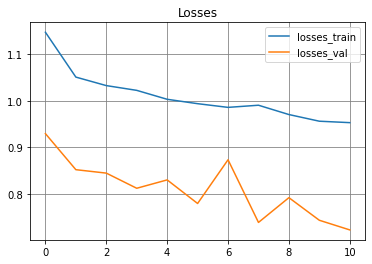

In [18]:
# распечатываем графики ошибок(loss функция - это DICE+BCE)

plt.grid(visible=True, color='0.5')

# Train
for experiment_id in losses_train.keys():
    plt.plot(losses_train[experiment_id], label=experiment_id)
plt.legend()
plt.title('Losses');

# Validation
for experiment_id in losses_val.keys():
    plt.plot(losses_val[experiment_id], label=experiment_id)
plt.legend()
plt.title('Losses');

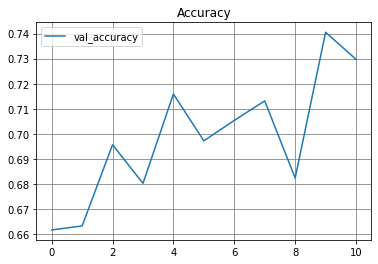

In [19]:
# Распечатываем график точности на валидационных данных

# Validation
for experiment_id in val_accuracy.keys():
    plt.plot(val_accuracy[experiment_id], label=experiment_id)
plt.legend()
plt.grid(visible=True, color='0.5')
plt.title('Accuracy');

In [24]:
# блок сохранения полученной модели
  
state = { 'info':      "U-Net for system of technical vision", # описание
         'date':      datetime.datetime.now(),                # дата и время
         'model' :    model.state_dict(),                     # параметры модели
         'optimizer': optimizer.state_dict()}                 # состояние оптимизатора
 
# Метод torch.save сохраняет в бинарном виде любой словарь,
# в том числе состояния модели и оптимизатора:
torch.save(state, 'state.pt')